In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=0.67545705/cloudy_fits/'

In [5]:
z_sys = 0.67545705

Obtain the UVB grid from FG20

In [6]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [7]:
z_test = 1

In [8]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [9]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [10]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [11]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [12]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [13]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [14]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# Line width trend

In [15]:
b_dict =  {'HI': '37, -1, +2',
        'CIII': '31, -2, +2',
        'CIV': '33, -4, +5',
        'OIII': '34, -2, +2',
        'OIV': '30, -2, +2',
        'OVI': '32, -3, +3'}

(26.0, 41.0)

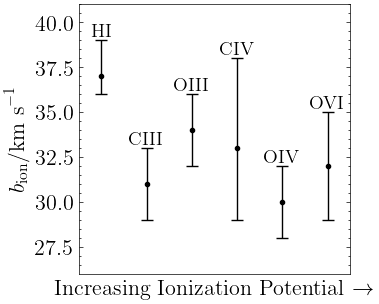

In [16]:
fig, ax = plt.subplots(1, figsize=(3.5,3.5))

plot_linewidth_obs(b_dict, fig, ax, fs=14)

ax.set_xlim(-0.5, len(b_dict)-1+0.5)
ax.set_ylim(26,41)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_lw.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

# Column density ratios

To predict the column density of the $i$-th ion of an element $X$ within a single gas phase (characterized by $n_{\mathrm{H}}$,) we first need to find the total hydrogen column density, as follows -

$$N_{\mathrm{H}} = N_{\mathrm{HI}} \times \frac{n_{\mathrm{H}}}{n_{\mathrm{HI}}} = \frac{N_{\mathrm{HI}}}{f_{\mathrm{HI}}}$$

Then, we can obtain the total column density of $X$ using the abundance [X/H] -

$$N_{\mathrm{X}} = N_{\mathrm{H}} \times 10^{\mathrm{[X/H]}}$$

Finally, we can get the column density of the ion $X_i$ using the ionization fraction $f_{X_i} = n_{\mathrm{X_i}}/n_{\mathrm{X}}$ -

$$N_{\mathrm{X_i}} = f_{X_i} \times N_{\mathrm{X}}$$

Putting all of this together -

$$N_{\mathrm{X_i}} = N_{\mathrm{HI}} \times \frac{f_{X_i}}{f_{\mathrm{HI}}} \times 10^{[\mathrm{X/H}]}$$

It is helpful to remember that ionizing fractions (at least in the low metallicity regime) only depend on the ionization parameter $U = n_{\gamma}/ n_{\mathrm{H}}$, so that -

$$\boxed{N_{\mathrm{X_i}} (N_{\mathrm{HI}}, U, [\mathrm{X/H}]) = N_{\mathrm{HI}} \times \frac{f_{X_i}}{f_{\mathrm{HI}}} (U) \times 10^{[\mathrm{X/H}]}}$$

Enter measurements for species

In [17]:
logN_dict = {'HI':'15.52, -0.05, +0.05',
            'CII':'<13.5',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.69, -0.05, +0.05',
            'NII':'<13.2',
            'NIII':'<13.4',
            'NV':'<14.0',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            'NeVIII':'<13.4',
            'MgII':'<11.4',
            'AlIII':'<12.5',
            'SiII':'<13.3',
            'SiIII':'<13.0',
            'SVI':'<13.0',
            'FeII':'<11.8',}

Get column density ratios

In [18]:
gen_logN_ratio_str(logN_dict['OVI'], logN_dict['OIV'])

'-0.71, -0.08, 0.06'

In [19]:
logN_ratio_dict = {'OIV/OIII': '0.57, -0.05, 0.07', #'>0.47, 0.33', 
                   'OVI/OIV': '-0.71, -0.08, 0.06', # '<-0.6, 0.3', 
                   'CIV/CIII': '-0.29, -0.07, 0.07', #'<-0.2, 0.3', 
                   #'SiIII/OIII': '<-1.4, 0.1',
                   #'SVI/OVI': '<-1.3, 0.1',
                  }

(-1.0, 0.9)

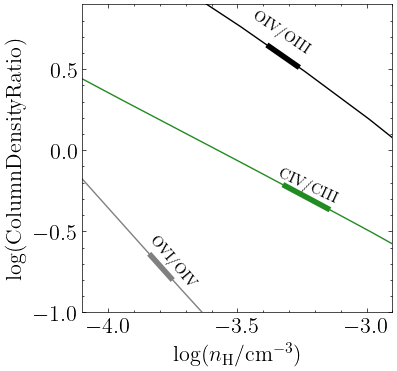

In [20]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-1.0,  colors=['black','grey','forestgreen','firebrick','navy','pink'])
ax.text(-3.35, -0.32, 'CIV/CIII', fontsize=11, rotation=-25)
ax.text(-3.45, 0.6, 'OIV/OIII', fontsize=11, rotation=-34)
ax.text(-3.85, -0.85, 'OVI/OIV', fontsize=11, rotation=-50)

#ax.text(-4.05, -1.55, 'SVI/OVI', fontsize=11, rotation=35)
#ax.text(-3.67, -1.7, 'SiIII/OIII', fontsize=11, rotation=25)

ax.set_xlim(-4.1, -2.9)
ax.set_ylim(-1., .9)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_frac.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

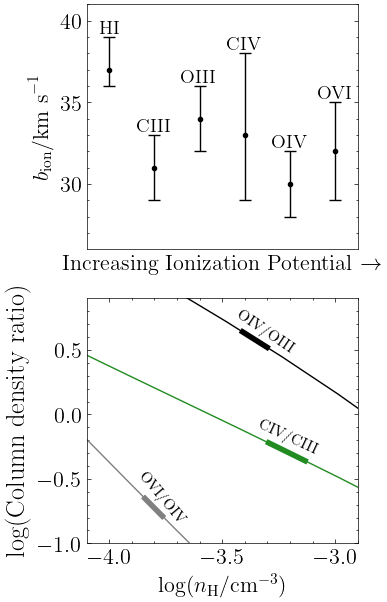

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(3.5,3.5*2))

plot_linewidth_obs(b_dict, fig, axes[0], fs=14)

axes[0].set_xlim(-0.5, len(b_dict)-1+0.5)
axes[0].set_ylim(26,41)

plot_logN_ratio(axes[1], species_logN_interp, logN_ratio_dict, label=False, logN_HI_ref=15.5, log_metals_ref=-1.0,  colors=['black','grey','forestgreen','firebrick','navy'])
axes[1].text(-3.35, -0.3, 'CIV/CIII', fontsize=11, rotation=-25)
axes[1].text(-3.45, 0.48, 'OIV/OIII', fontsize=11, rotation=-34)
axes[1].text(-3.88, -0.85, 'OVI/OIV', fontsize=11, rotation=-50)

#axes[1].text(-4.05, -1.6, 'SVI/OVI', fontsize=11, rotation=32)
#axes[1].text(-3.65, -1.7, 'SiIII/OIII', fontsize=11, rotation=23)

axes[1].set_xlim(-4.1, -2.9)
axes[1].set_ylim(-1.0, 0.9)
axes[1].set_ylabel(r'$\log(\mathrm{Column \ density \ ratio})$', fontsize=19)

#axes[1].legend(fontsize=11, loc='lower left')

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_lw+frac.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

# Two-phase solution

In [22]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O_p1, 'N':N_O_p1}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2, 'N':N_O_p2}])
    
    x = log_prior_two_phase(params_full, species_logN_interp)
    
    if np.isfinite(x):
        logN_OIV_p1 = species_logN_interp['O+3']((logN_HI_test, log_hdens_p1, log_metals_p1))
        logN_OIV_p2 = species_logN_interp['O+3']((logN_HI_p2, log_hdens_p2, log_metals_p2))
        
        if logN_OIV_p1 < logN_OIV_p2: # OIV mostly in the low-density phase
            return x
        else: 
            return -np.inf
    else:
        return -np.inf

In [23]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O_p1, 'N':N_O_p1}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2, 'N':N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [24]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [25]:
logN_dict = {'HI':'15.52, -0.05, +0.05',
            'CII':'<13.5',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.69, -0.05, +0.05',
            'NII':'<13.2',
            'NIII':'<13.4',
            'NV':'<14.0',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            'MgII':'<11.4',
            #'AlIII':'<12.5',
            'SiII':'<13.3',
            'SiIII':'<13.0',
            'SVI':'<13.0',}
            #'FeII':'<11.8',}

In [26]:
logN_HI_test = 15.52
log_hdens_test_p1 = -3.1 #-3.1
log_metals_test_p1 = -0.8
C_O_test_p1 = -0.35
N_O_test_p1 = -1.0

logN_HI_test_p2 = 14.5
log_hdens_test_p2 = -3.85
log_metals_test_p2 = -0.15
C_O_test_p2 = -2.0
N_O_test_p2 = -2.0

In [27]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp, {'C':C_O_test_p1, 'N':N_O_test_p1}))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp, {'C':C_O_test_p2, 'N':N_O_test_p2}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

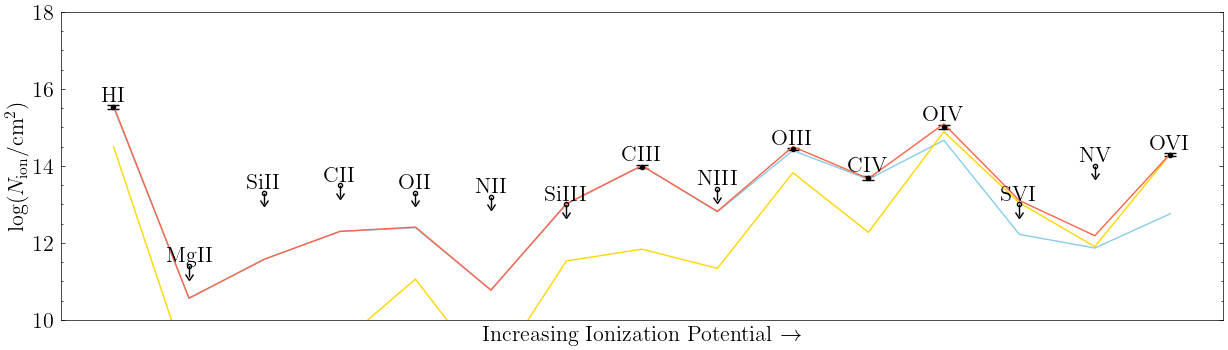

In [28]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='tomato')

#ax.set_ylim(12,16.5)

In [29]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [30]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [31]:
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [07:24<00:00,  2.25it/s]


In [32]:
flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1',
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
flat_samples_two_phase.to_csv(savedir+'two_phase.csv', index=False)

#flat_samples_two_phase = pd.read_csv(savedir+'two_phase.csv')

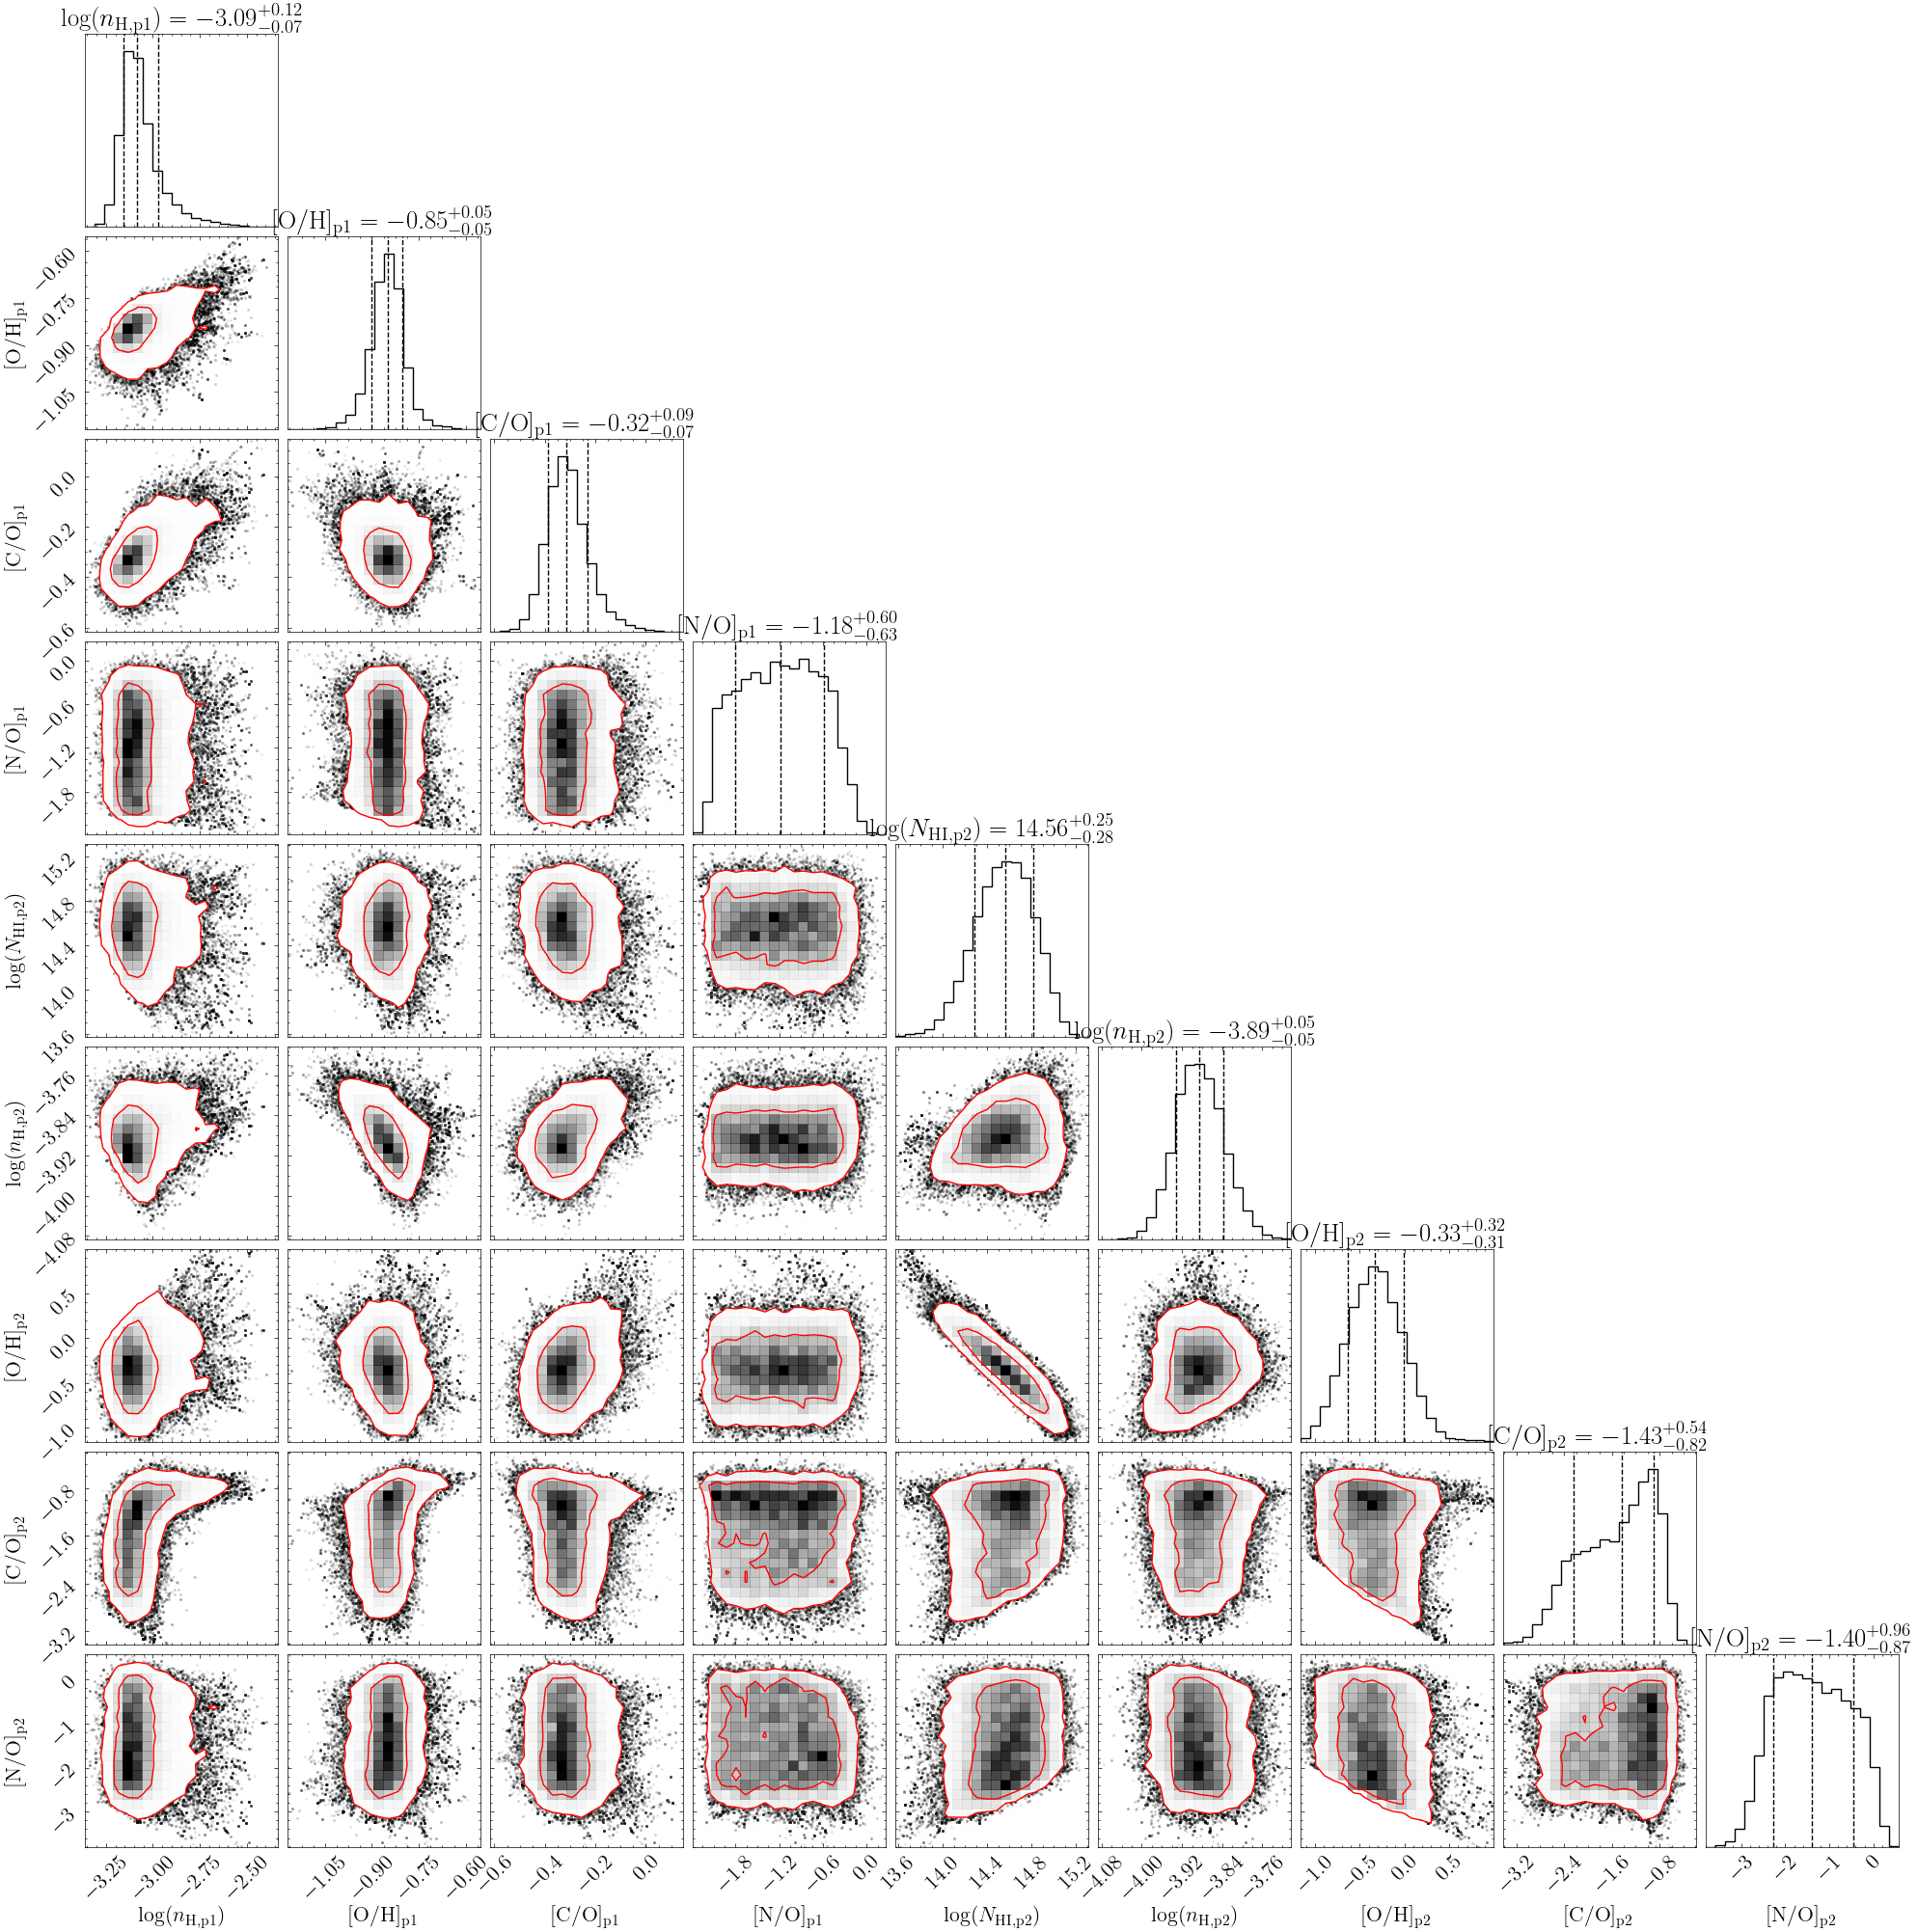

In [33]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [35]:
np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_3sig)

-0.012625612322012064

In [34]:
np.median(flat_samples_two_phase['log_metals_p1'])

-0.8503331172144694

In [36]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(13.698594261986681, 15.159913590955357)

In [37]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-1.084857795356946, 0.8489290124593973)

In [38]:
np.percentile(flat_samples_two_phase['C_O_p2'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p2'], 100*cdf_3sig)

(-0.4556714640291608, 0.31660412247058844)

Now plot the best models

In [39]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.5',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.69, -0.05, +0.05',
            #'NII':'<13.2',
            'NIII':'<13.4',
            'NV':'<14.0',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            'NeVIII':'<13.4',
            #'MgII':'<11.4',
            #'AlIII':'<12.5',
            #'SiII':'<13.3',
            'SiIII':'<13.0',
            'SVI':'<13.0',}
            #'FeII':'<11.8',}

In [40]:
b_dict =  {'HI': '37, -1, +2',
        'CIII': '31, -2, +2',
        'CIV': '33, -4, +5',
        'OIII': '34, -2, +2',
        'OIV': '30, -2, +2',
        'OVI': '32, -3, +3'}

In [41]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

In [42]:
z_sys = 0.67545705

In [43]:
import matplotlib.lines as mlines

In [44]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples_two_phase['log_hdens_p1']), 
                                        np.median(flat_samples_two_phase['log_metals_p1']), 
                                        species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p1']), 
                                                              'N':np.median(flat_samples_two_phase['N_O_p1'])})

logN_species_p2_best = predict_col_dens(logN_dict, np.median(flat_samples_two_phase['logN_HI_p2']), 
                                        np.median(flat_samples_two_phase['log_hdens_p2']), 
                                        np.median(flat_samples_two_phase['log_metals_p2']), 
                                                 species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p2']), 'N':np.median(flat_samples_two_phase['N_O_p2'])})

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [45]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [46]:
logN_res_dict

{'OII': '<0.9',
 'SiIII': '<0.0',
 'CIII': '-0.02, -0.05, 0.05',
 'NIII': '<0.8',
 'OIII': '-0.0, -0.02, 0.02',
 'CIV': '0.02, -0.05, 0.05',
 'OIV': '-0.02, -0.05, 0.07',
 'SVI': '<0.0',
 'NV': '<1.5',
 'OVI': '-0.02, -0.03, 0.03',
 'NeVIII': '<1.6'}

In [47]:
logN_res_up = {k:'<0.4' for k in list(logN_res_dict.keys())}

logN_res_up['OII'] = '<0.18'
logN_res_up['NIII'] = '<0.18'
logN_res_up['NV'] = '<0.18'
logN_res_up['NeVIII'] = '<0.18'

In [48]:
# Model curves for each step
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [49]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_two_phase['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_two_phase)):
    log_hdens_p1 = flat_samples_two_phase['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_two_phase['log_metals_p1'][i]
    C_O_p1 = flat_samples_two_phase['C_O_p1'][i]
    log_hdens_p2 = flat_samples_two_phase['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

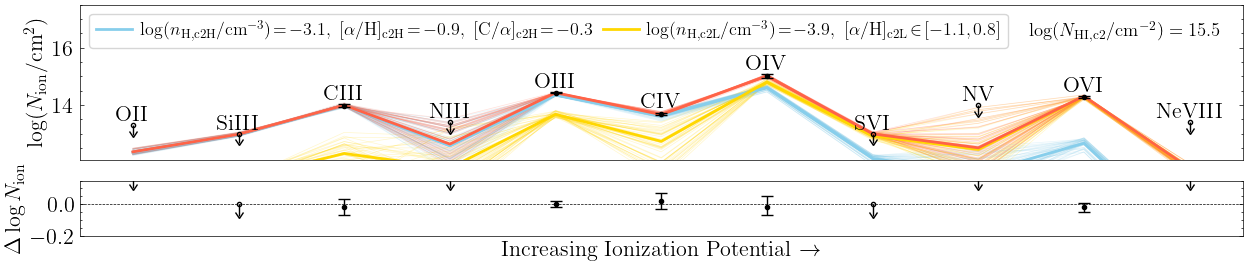

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

for idx in plot_idx:
    axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    axes[0].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
axes[0].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)
   

plot_column_densities_obs(logN_dict, fig, axes[0], c_dy=1.7)

axes[0].set_ylim(12.1,17.5)

axes[0].set_xlabel(None)

axes[0].text(len(logN_dict)-.7, 16.4, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 15.5$', fontsize=13.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) \!=\! -3.1, \ \mathrm{[\alpha/H]_{c2H}}\!=\!-0.9, \ \mathrm{[C/\alpha]_{c2H}}\!=\!-0.3$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) \!=\! -3.9, \ \mathrm{[\alpha/H]_{c2L}}\!\in\![-1.1,0.8]$'))
    
axes[0].legend(handles=handles, loc='upper left', fontsize=13, ncol=2, columnspacing=.6, handletextpad=0.4)

plot_column_densities_obs(logN_res_dict, fig, axes[1], label_ions=False, dy=.05)
# For non-detections not in residual panel
plot_column_densities_obs(logN_res_up, fig, axes[1], label_ions=False, dy=.05)

axes[1].set_ylim(-0.2,0.15)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Get cloud sizes

In [51]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

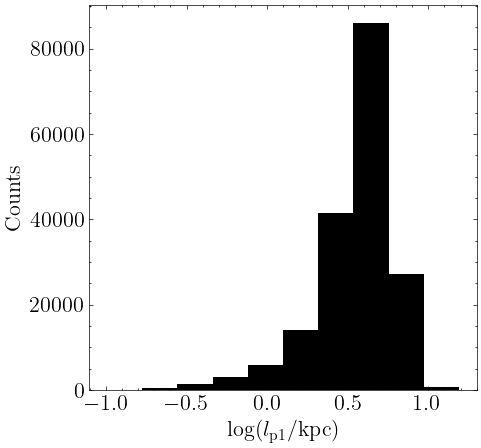

In [52]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/ \mathrm{kpc})$')
ax.set_ylabel('Counts')

In [53]:
get_quantiles(np.log10(l_p1))

0.6 -0.25 0.15


In [54]:
np.percentile(np.log10(l_p1),100*cdf_1sig)-np.median(np.log10(l_p1))

0.1532143059026575

In [55]:
np.median(np.log10(l_p1))-np.percentile(np.log10(l_p1),100*(1-cdf_1sig))

0.24773152932420328

Text(0, 0.5, 'Counts')

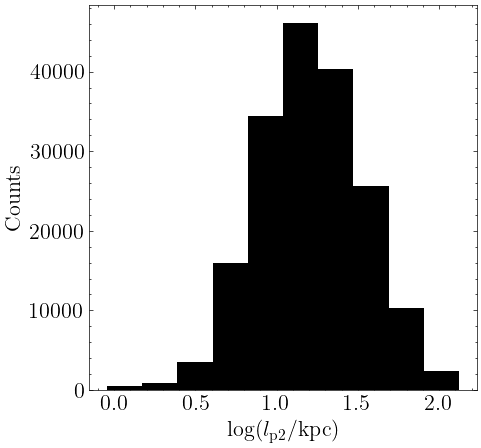

In [56]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/ \mathrm{kpc})$')
ax.set_ylabel('Counts')

In [57]:
get_quantiles(np.log10(l_p2))

1.2 -0.33 0.34


In [58]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(0.10573862160382487, 2.0395919024224765)

# Single phase solution

In [65]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [66]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [67]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [94]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            'CII':'<13.5',
            #'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            'NII':'<13.2',
            'NIII':'<13.4',
            'NV':'<14.0',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            #'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            'MgII':'<11.4',
            #'AlIII':'<12.5',
            'SiII':'<13.3',
            'SiIII':'<13.0',
            'SVI':'<13.0',}
            #'FeII':'<11.8'}

In [95]:
logN_HI_test = 15.52
log_hdens_test = -3.3
log_metals_test = -0.7
C_O_test = -0.7
N_O_test = -1.0

In [96]:
#species_logN_interp['Si+2']([logN_HI_test, log_hdens_test_p1, log_metals_test_p1])[0]

In [97]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

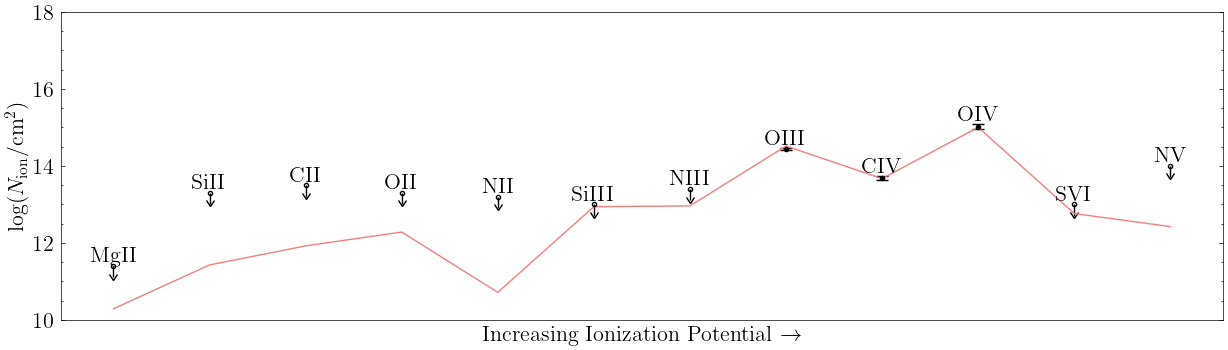

In [98]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [99]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [100]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [103]:
#sampler.run_mcmc(pos, 500, progress=True);

In [104]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'one_phase.csv', index=False)

flat_samples = pd.read_csv(savedir+'one_phase.csv')

In [105]:
#flat_samples

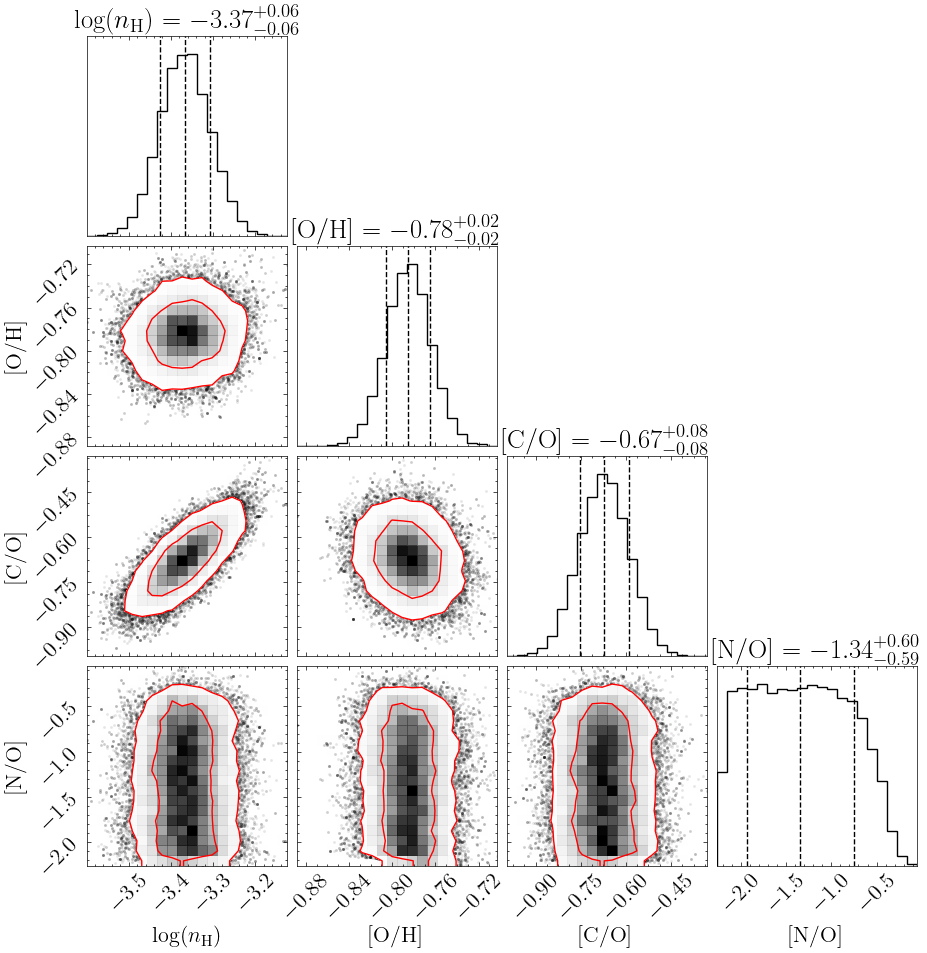

In [106]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$', r'$[\mathrm{N/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [107]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

-0.1944858537553625

Now plot the best models

In [150]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.5',
            'CIII': '13.98, -0.05, +0.05', # '>13.9',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.2',
            'NIII':'<13.4',
            'NV':'<14.0',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07', # '>14.9',
            'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            #'MgII':'<11.4',
            #'AlIII':'<12.5',
            #'SiII':'<13.3',
            'SiIII':'<13.0',
            'SVI':'<13.0',}
            #'FeII':'<11.8'}

In [151]:
b_dict =  {'HI': '36, -1, +2',
        'CIII': '31, -2, +2',
        'CIV': '33, -4, +5',
        'OIII': '34, -2, +2',
        'OIV': '30, -2, +2',
        'OVI': '32, -3, +3'}

In [152]:
import matplotlib.lines as mlines

In [153]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [154]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [173]:
logN_res_up = {k:'<0.5' for k in list(logN_res_dict.keys())}

logN_res_up['OII'] = '<0.36'
logN_res_up['NIII'] = '<0.36'
logN_res_up['NV'] = '<0.36'
logN_res_up['OVI'] = '<0.36'

In [174]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [175]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

(26.0, 41.0)

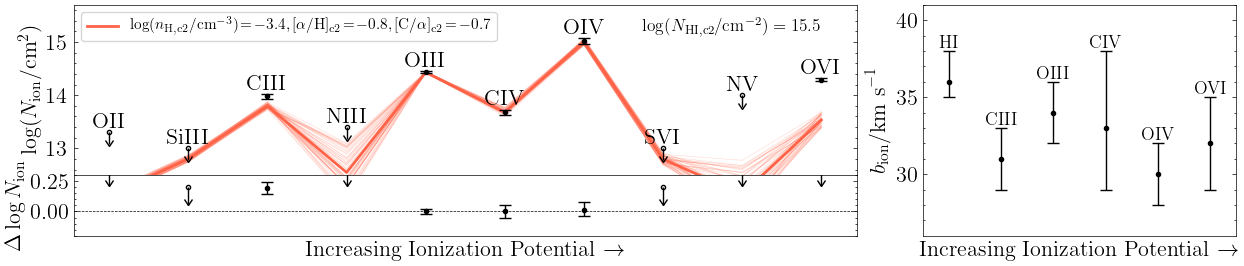

In [180]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], dy=.15)

axd['upper left'].set_ylim(12.5,15.7)

axd['upper left'].text(len(logN_dict)-1, 15.2, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 15.5$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c2}/\mathrm{cm}^{-3}) \!=\! -3.4, \mathrm{[\alpha/H]_{c2}} \!=\! -0.8, \mathrm{[C/\alpha]_{c2}}\!=\!-0.7$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=11)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.1)

axd['lower left'].set_ylim(-.2,.3)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13)
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(26,41)

Get cloud sizes

In [166]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

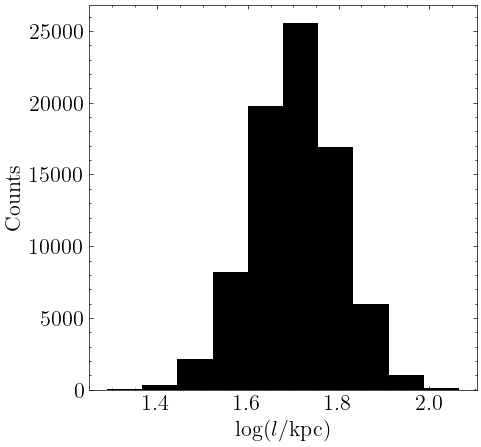

In [47]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [48]:
get_quantiles(np.log10(l))

1.71 -0.1 0.09


# DRAFT

In [15]:
logN_HI_test = 15.52
log_hdens_test = -3.4
log_metals_test = -0.6

In [16]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp)

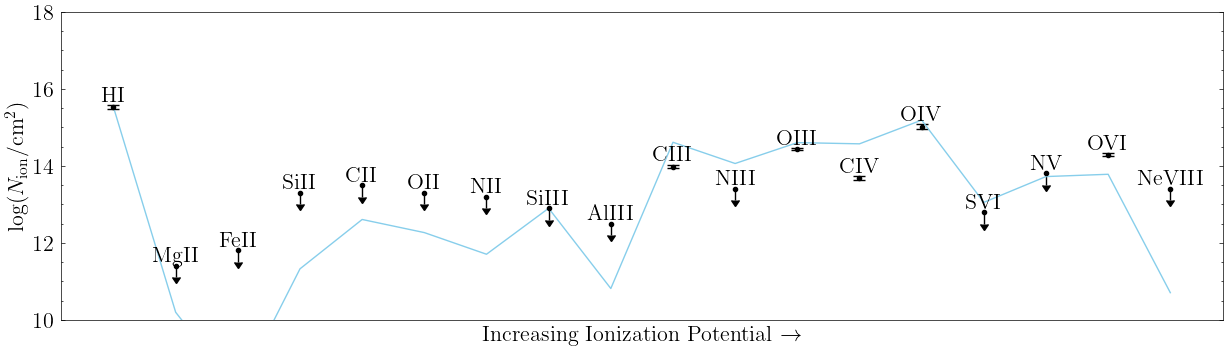

In [17]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='skyblue')

# Using OVI as a detection

## Two-phase solution - low density phase

In [149]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.5',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.2',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            #'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            #'MgII':'<11.4',
            #'AlIII':'<12.5',
            #'SiII':'<13.3',
            'SiIII':'<12.9',
            'SVI':'<12.8',}
            #'FeII':'<11.8'}

Fit the density

In [22]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [23]:
pos = np.array(-3.9) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [24]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [25]:
#sampler.run_mcmc(pos, 500, progress=True);

In [26]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo_OVI.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo_OVI.csv')

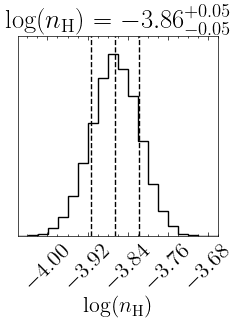

In [27]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [28]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [29]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

Text(0.5, 0, '$\\log N_{\\mathrm{OIV, ref}}$')

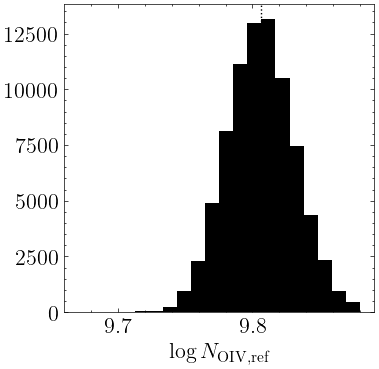

In [30]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{CIV, ref}}$')

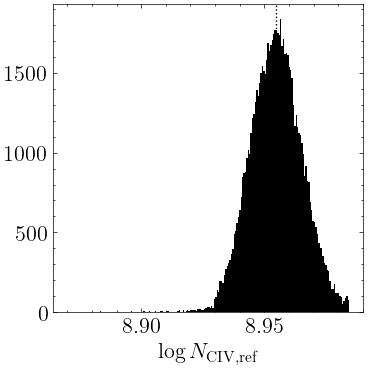

In [31]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+3'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['C+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{OIII, ref}}$')

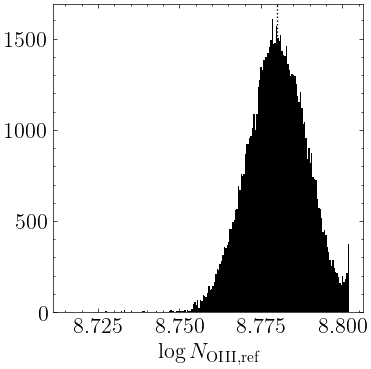

In [32]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['O+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{CIII, ref}}$')

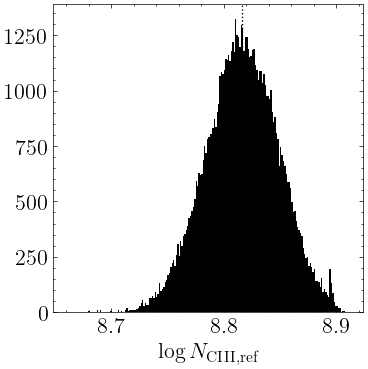

In [33]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['C+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [34]:
logN_offset = 15.01-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [35]:
logN_offset

5.20405081987734

Calculate the C/O ratio

In [36]:
logN_CIV_obs = np.random.normal(loc=13.68, scale=0.05, size=len(flat_samples_hdens))

In [37]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [38]:
get_quantiles(C_O_dist)

-0.48 -0.05 0.05


Get yields

In [39]:
#get_quantiles(logN_offset+species_logN_interp['O+3'](grid_points_hdens))

In [40]:
#get_quantiles(logN_offset-0.4+species_logN_interp['C+3'](grid_points_hdens))

In [41]:
get_quantiles(logN_offset-0.48+species_logN_interp['C+2'](grid_points_hdens))

13.54 -0.03 0.03


In [42]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

13.98 -0.01 0.01


Plot models

In [43]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.5',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.2',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            #'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            'NeVIII':'<13.4',
            #'MgII':'<11.4',
            #'AlIII':'<12.5',
            #'SiII':'<13.3',
            #'SiIII':'<12.9',
            'SVI':'<12.8',}
            #'FeII':'<11.8'}

In [44]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

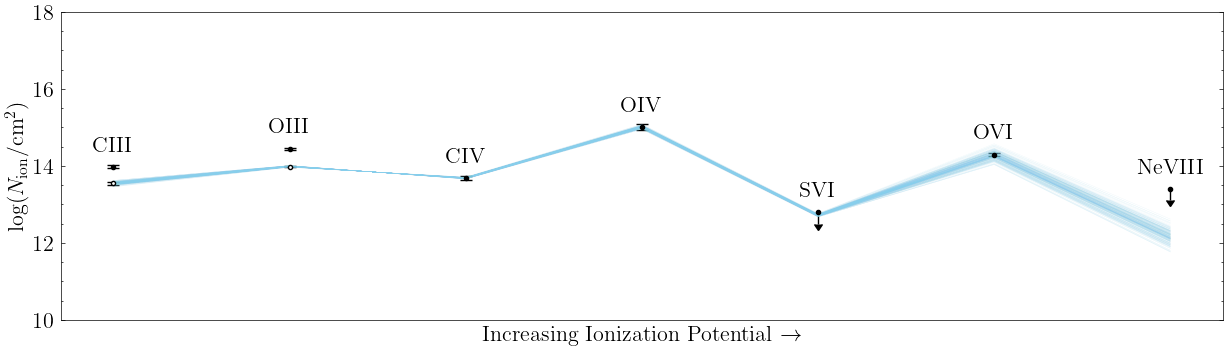

In [45]:
fig, ax = plot_column_densities_obs(logN_dict)

ax.errorbar(x=0, y=13.54, yerr=0.03, color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

ax.errorbar(x=1, y=13.98, yerr=0.01, color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

Calculate residual for OIII

In [46]:
logN_OIII_tot = np.random.normal(loc=14.43, scale=0.02, size=1000)
logN_OIII_lo_dens = np.random.normal(loc=13.98, scale=0.01, size=1000)
logN_OIII_hi_dens = np.log10(10**logN_OIII_tot - 10**logN_OIII_lo_dens)

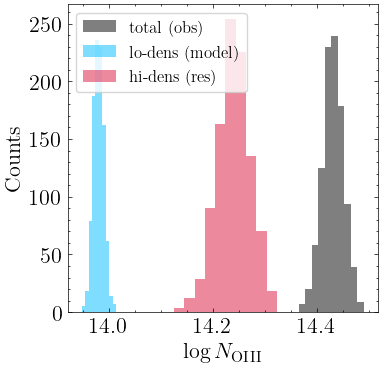

In [47]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_OIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_OIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_OIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{OIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [48]:
logN_OIII_hi_dens_clean = logN_OIII_hi_dens[~np.isnan(logN_OIII_hi_dens)]

In [49]:
get_quantiles(logN_OIII_hi_dens_clean)

14.24 -0.03 0.03


Calculate residual for CIII

In [50]:
logN_CIII_tot = np.random.normal(loc=13.98, scale=0.05, size=1000)
logN_CIII_lo_dens = np.random.normal(loc=13.54, scale=0.03, size=1000)
logN_CIII_hi_dens = np.log10(10**logN_CIII_tot - 10**logN_CIII_lo_dens)

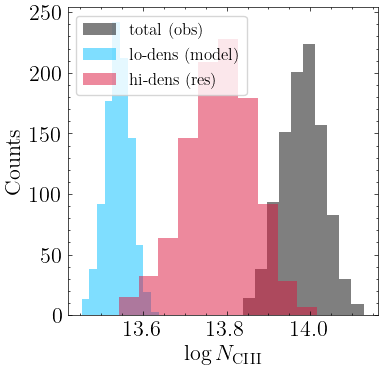

In [51]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_CIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_CIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_CIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{CIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [52]:
logN_CIII_hi_dens_clean = logN_CIII_hi_dens[~np.isnan(logN_CIII_hi_dens)]

In [53]:
get_quantiles(logN_CIII_hi_dens_clean)

13.79 -0.09 0.08


## Two-phase solution - high density phase

In [54]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            'CII':'<13.5',
            'CIII':'13.78, -0.09, +0.08',
            'CIV':'<13.68',
            #'NII':'<13.2',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.3',
            'OIII':'14.24, -0.03, +0.03',
            'OIV':'<15.01',
            #'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            'MgII':'<11.4',
            #'AlIII':'<12.5',
            'SiII':'<13.3',}
            #'SiIII':'<12.9',
            #'SVI':'<12.8',
            #'FeII':'<11.8'}

Get column density ratios

In [55]:
gen_logN_ratio_str(logN_dict['MgII'], logN_dict['OIII'])

'<-2.84, 0.14'

In [56]:
logN_ratio_dict = {'CII/CIII': '<-0.3, 0.2',
                   'CIV/CIII': '<-0.1, 0.2',
                   #'SiII/OIII': '<-0.9, 0.1',
                   'OII/OIII': '<-0.9, 0.1',
                   'OIV/OIII': '<0.8, 0.1',
                   'MgII/OIII':  '<-2.8, 0.1'
                  }

(-5.0, 5.0)

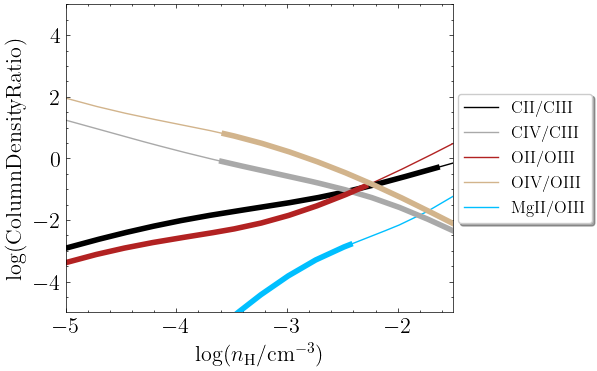

In [57]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [58]:
pos = np.array(-3) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [59]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [60]:
#sampler.run_mcmc(pos, 500, progress=True);

In [61]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_hi_OVI.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_hi_OVI.csv')

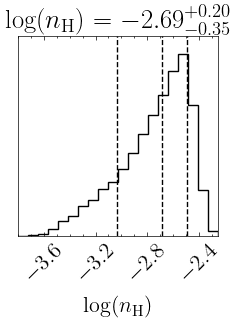

In [62]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [63]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [64]:
logN_offset = 14.24-np.median(species_logN_interp['O+2'](grid_points_hdens))

In [65]:
logN_offset

5.69186466326005

Calculate the C/O ratio

In [66]:
logN_CIII_obs = np.random.normal(loc=13.78, scale=0.08, size=len(flat_samples_hdens))

In [67]:
C_O_dist_CIII = logN_CIII_obs-(logN_offset+species_logN_interp['C+2'](grid_points_hdens))
C_O_dist = C_O_dist_CIII

In [68]:
get_quantiles(C_O_dist)

-0.32 -0.32 0.23


Plot models

In [69]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            'CII':'<13.5',
            'CIII':'13.78, -0.09, +0.08',
            'CIV':'<13.68',
            #'NII':'<13.2',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.3',
            'OIII':'14.24, -0.03, +0.03',
            'OIV':'<15.01',
            #'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            'MgII':'<11.4',
            #'AlIII':'<12.5',
            'SiII':'<13.3',}
            #'SiIII':'<12.9',
            #'SVI':'<12.8',
            #'FeII':'<11.8'}

In [70]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

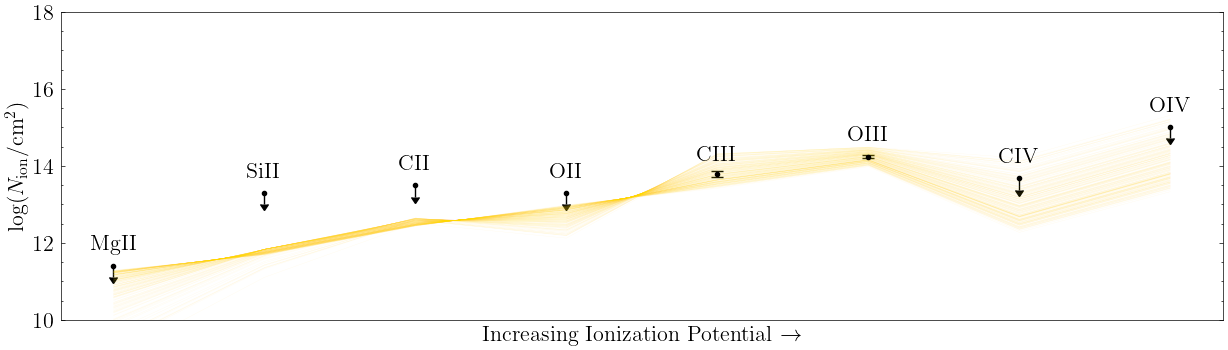

In [71]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='gold', lw=.2, alpha=.1)

In [72]:
get_cloud_size(15.52, -2.7, species_logN_interp)

0.7310900604288831

## Two-phase solution: simultaneous

In [73]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [74]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [75]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [76]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.5',
            #'CIII':'13.98, -0.05, +0.05',
            #'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.2',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',}
            #'NeVIII':'<13.4',
            #'MgII':'<11.4',
            #'AlIII':'<12.5',
            #'SiII':'<13.3',
            #'SiIII':'<12.9',
            #'SVI':'<12.8',}
            #'FeII':'<11.8'}

In [77]:
logN_HI_test_p1 = 15.52
log_hdens_test_p1 = -2.9
log_metals_test_p1 = -0.6

logN_HI_test_p2 = 15.0
log_hdens_test_p2 = -3.9
log_metals_test_p2 = -0.8

In [78]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

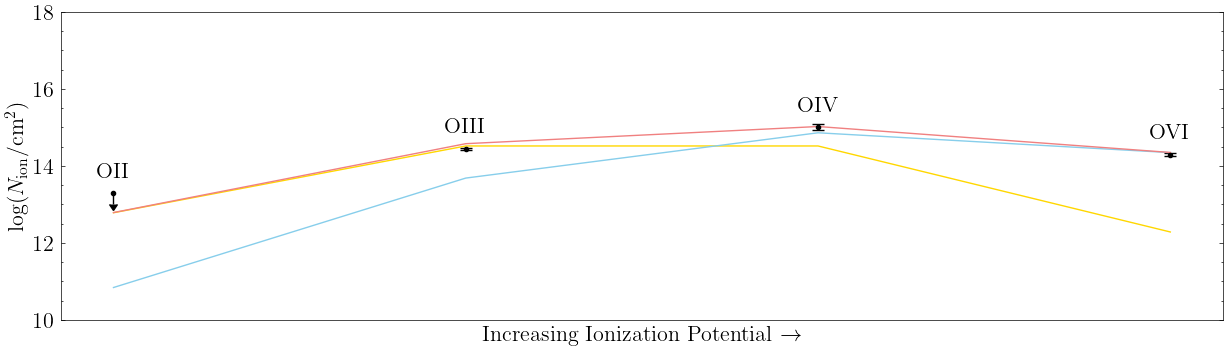

In [79]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [80]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2]) + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [81]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [82]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [83]:
#sampler.run_mcmc(pos, 500, progress=True);

In [84]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_OVI.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_OVI.csv')

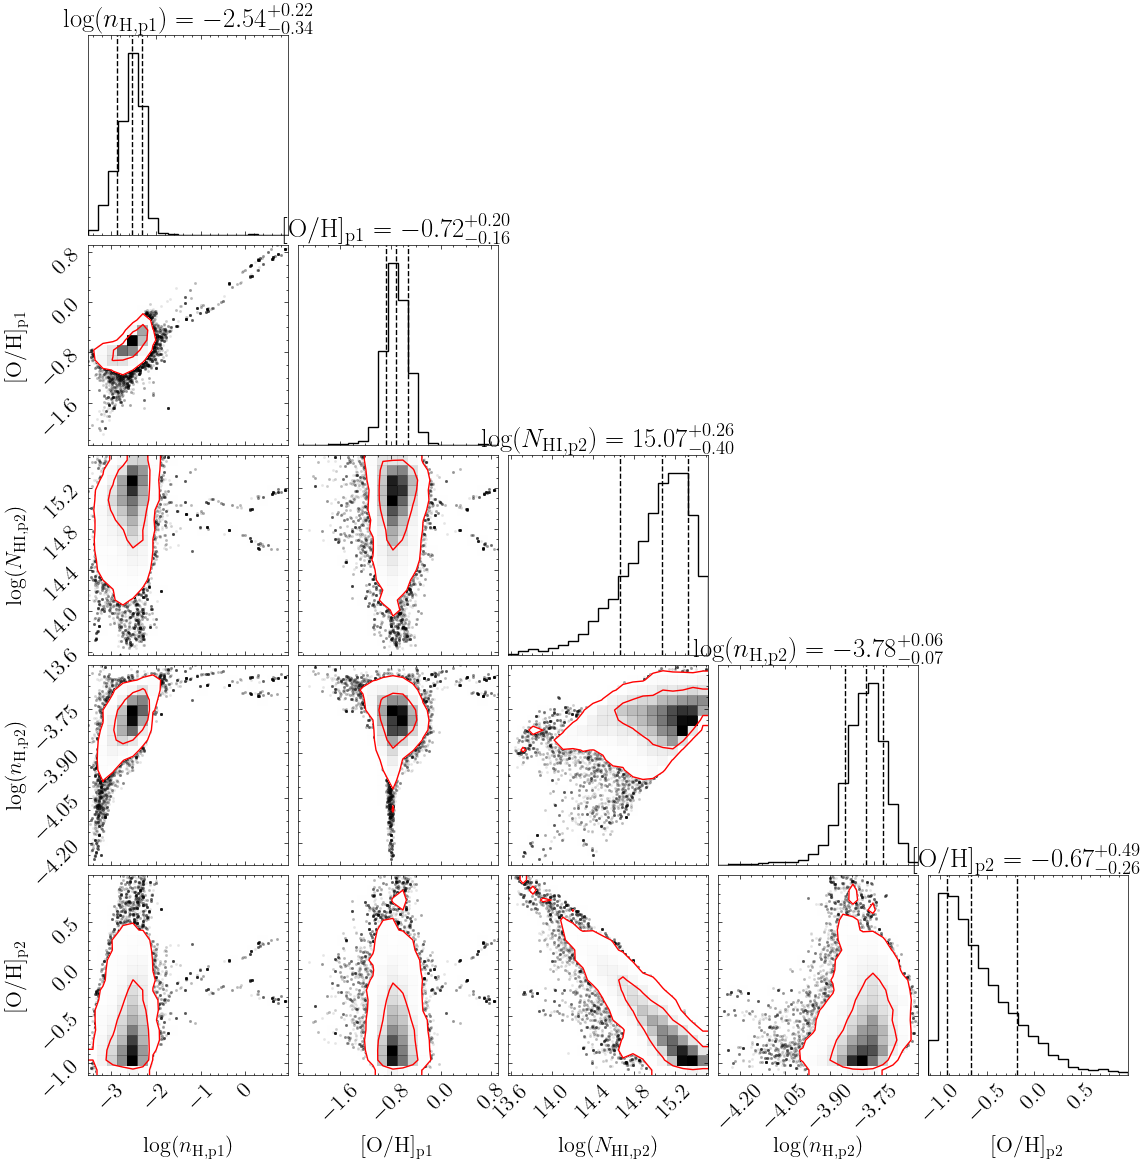

In [85]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [86]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.5',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.2',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.3',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            'NeVIII':'<13.4',
            'MgII':'<11.4',
            #'AlIII':'<12.5',
            'SiII':'<13.3',
            'SiIII':'<12.9',
            'SVI':'<12.8',}
            #'FeII':'<11.8'}

In [87]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

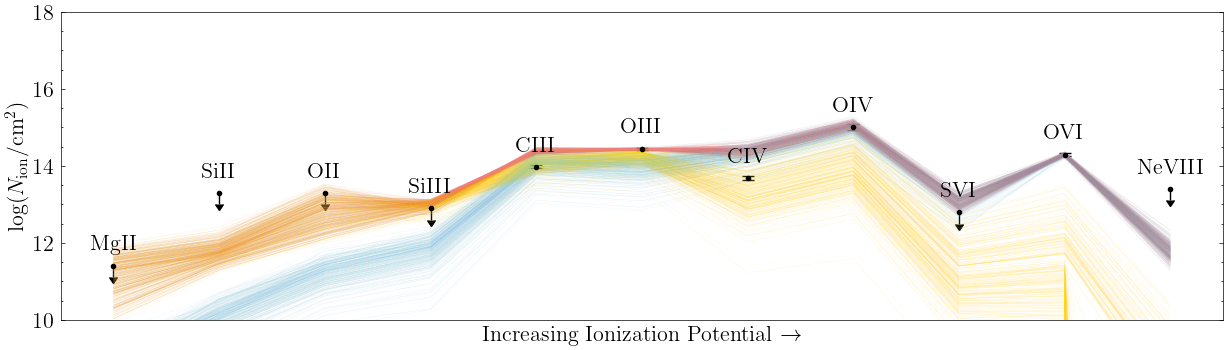

In [88]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)

Get cloud sizes

In [89]:
#l_p1 = np.zeros(len(flat_samples_two_phase))
#l_p2 = np.zeros(len(flat_samples_two_phase))

In [90]:
#for i in range(len(l_p1)):
    
#    flat_samples_row = flat_samples_two_phase.iloc[i]
    
#    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
#    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)

In [91]:
#fig, ax = plt.subplots(1, figsize=(5,5))

#ax.hist(l_p1, bins=10)

#ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [92]:
#np.percentile(l_p1, 100*cdf_3sig)

In [93]:
#np.median(l_p1)

In [94]:
#fig, ax = plt.subplots(1, figsize=(5,5))

#ax.hist(l_p2, bins=10)

#ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [95]:
#np.percentile(l_p2, 100*cdf_3sig)

In [96]:
#np.median(l_p2)

## Three phase solution

In [ ]:
def lambda_log_prior_three_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}, logN_HI_p3, log_hdens_p3, log_metals_p3, {}])
    
    return log_prior_three_phase(params_full, species_logN_interp)

In [ ]:
def lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}, logN_HI_p3, log_hdens_p3, log_metals_p3, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_three_phase(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_three_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            #'CII':'<13.4',
            #'CIII':'13.98, -0.05, +0.05',
            #'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.1',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.2',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            'MgII':'<11.2',
            #'AlIII':'<12.3',
            #'SiII':'<13.1',
            #'SiIII':'<13.0',
            'SVI':'<12.8',}
            #'FeII':'<11.6',}

In [ ]:
logN_HI_test_p1 = 15.52
log_hdens_test_p1 = 0
log_metals_test_p1 = -2.5

logN_HI_test_p2 = 15.2
log_hdens_test_p2 = -2.9
log_metals_test_p2 = -0.5

logN_HI_test_p3 = 14.7
log_hdens_test_p3 = -3.8
log_metals_test_p3 = -0.3

In [ ]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [ ]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2,
                logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3]) + 1e-4 * np.random.randn(200, 8)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [ ]:
sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
flat_samples_three_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1', 
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2',
                                         'logN_HI_p3', 'log_hdens_p3', 'log_metals_p3'])
flat_samples_three_phase.to_csv(savedir+'three_phase_OVI.csv', index=False)

#flat_samples_three_phase = pd.read_csv(savedir+'three_phase_OVI.csv')

In [ ]:
fig = corner.corner(
    flat_samples_three_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$\log(N_\mathrm{HI, p3})$', r'$\log(n_\mathrm{H, p3})$', r'$[\mathrm{O/H}]_{\mathrm{p3}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [ ]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            'CII':'<13.4',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.1',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.2',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            'NeVIII':'<13.4',
            'MgII':'<11.2',
            #'AlIII':'<12.3',
            'SiII':'<13.1',
            #'SiIII':'<13.0',
            'SVI':'<12.8',}
            #'FeII':'<11.6',}

In [ ]:
sample_indices_three_phase = np.random.randint(low=0, high=len(flat_samples_three_phase), size=500)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_three_phase)):
    
    idx = sample_indices_three_phase[i]
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_HI_p3 = flat_samples_row['logN_HI_p3']
    log_hdens_p3 = flat_samples_row['log_hdens_p3']
    log_metals_p3 = flat_samples_row['log_metals_p3']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))
    logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_p3,  log_hdens_p3, log_metals_p3, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue', lw=.2, alpha=.1)


## Three phase solution (revisited)

In [ ]:
def lambda_log_prior_three_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, logN_HI_p3, log_hdens_p3, log_metals_p3, C_O_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, 
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2}, 
                            logN_HI_p3, log_hdens_p3, log_metals_p3, {'C':C_O_p3}])
    
    return log_prior_three_phase(params_full, species_logN_interp)

In [ ]:
def lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, logN_HI_p3, log_hdens_p3, log_metals_p3, C_O_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, 
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2}, 
                            logN_HI_p3, log_hdens_p3, log_metals_p3, {'C':C_O_p3}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_three_phase(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_three_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            'CII':'<13.4',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.1',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.2',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            #'NeVIII':'<13.4',
            'MgII':'<11.2',
            #'AlIII':'<12.3',
            #'SiII':'<13.1',
            #'SiIII':'<13.0',
            'SVI':'<12.8',}
            #'FeII':'<11.6',}

In [ ]:
logN_HI_test_p1 = 15.52
log_hdens_test_p1 = 0
log_metals_test_p1 = -2.5

logN_HI_test_p2 = 15.2
log_hdens_test_p2 = -2.9
log_metals_test_p2 = -0.5
C_O_p2 = -0.2

logN_HI_test_p3 = 14.7
log_hdens_test_p3 = -3.8
log_metals_test_p3 = -0.3
C_O_p3 = -1.0

In [ ]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp, {'C':C_O_p2}))
logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, species_logN_interp, {'C':C_O_p3}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [ ]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_p2,
                logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, C_O_p3]) + 1e-4 * np.random.randn(200, 10)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_three_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2',
#                                         'logN_HI_p3', 'log_hdens_p3', 'log_metals_p3', 'C_O_p3'])
#flat_samples_three_phase.to_csv(savedir+'three_phase_C.csv', index=False)

flat_samples_three_phase = pd.read_csv(savedir+'three_phase_C.csv')

In [ ]:
#fig = corner.corner(
#    flat_samples_three_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
#    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
#            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
#            r'$[\mathrm{C/O}]_{\mathrm{p2}}$',
#            r'$\log(N_\mathrm{HI, p3})$', r'$\log(n_\mathrm{H, p3})$', r'$[\mathrm{O/H}]_{\mathrm{p3}}$',
#            r'$[\mathrm{C/O}]_{\mathrm{p3}}$'], 
#    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
#);

In [ ]:
np.percentile(flat_samples_three_phase['log_hdens_p1'], 100*(1-cdf_3sig))

In [ ]:
np.percentile(flat_samples_three_phase['log_metals_p1'], 100*cdf_3sig)

Now plot the best models

In [ ]:
logN_dict = {#'HI':'15.52, -0.05, +0.05',
            'CII':'<13.4',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.68, -0.05, +0.05',
            #'NII':'<13.1',
            #'NIII':'<13.4',
            #'NV':'<13.8',
            'OII':'<13.2',
            'OIII':'14.43, -0.02, +0.02',
            'OIV':'15.01, -0.05, +0.07',
            'OVI':'14.29, -0.03, +0.03',
            'NeVIII':'<13.4',
            'MgII':'<11.2',
            #'AlIII':'<12.3',
            'SiII':'<13.1',
            #'SiIII':'<13.0',
            'SVI':'<12.8',}
            #'FeII':'<11.6',}

In [ ]:
b_dict =  {'HI': '36, -1, +2',
        'CIII': '31, -2, +2',
        'CIV': '33, -4, +5',
        'OIII': '34, -2, +2',
        'OIV': '30, -2, +2',
        'OVI': '32, -3, +3'}

In [ ]:
sample_indices_three_phase = np.random.randint(low=0, high=len(flat_samples_three_phase), size=100)

In [ ]:
z_sys = 0.67545705

In [ ]:
import matplotlib.lines as mlines

In [ ]:
logN_species_p1_grid = np.zeros((len(logN_dict), len(sample_indices_three_phase)))
logN_species_p2_grid = np.zeros((len(logN_dict), len(sample_indices_three_phase)))
logN_species_p3_grid = np.zeros((len(logN_dict), len(sample_indices_three_phase)))
logN_species_grid = np.zeros((len(logN_dict), len(sample_indices_three_phase)))

fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [3, 1]})

for i in range(len(sample_indices_three_phase)):
    
    idx = sample_indices_three_phase[i]
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    C_O_p2 = flat_samples_row['C_O_p2']
    
    logN_HI_p3 = flat_samples_row['logN_HI_p3']
    log_hdens_p3 = flat_samples_row['log_hdens_p3']
    log_metals_p3 = flat_samples_row['log_metals_p3']
    C_O_p3 = flat_samples_row['C_O_p3']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp,
                                                    {'C':C_O_p2}))
    logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_p3,  log_hdens_p3, log_metals_p3, species_logN_interp,
                                                    {'C':C_O_p3}))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)
    
    logN_species_p1_grid[:,i] = logN_species_test_p1
    logN_species_p2_grid[:,i] = logN_species_test_p2
    logN_species_p3_grid[:,i] = logN_species_test_p3
    logN_species_grid[:,i] = logN_species_test

    # Plot
    #ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.1, alpha=.1)
    #ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen', lw=.1, alpha=.1)
    #ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold', lw=.1, alpha=.1)
    #ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue', lw=.1, alpha=.1)

logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_p3_med = np.median(logN_species_p3_grid, axis=1)
logN_species_p3_lo = np.percentile(logN_species_p3_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p3_hi = np.percentile(logN_species_p3_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_p1_lo, logN_species_p1_hi,
                color='forestgreen', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_p1_med, color='forestgreen', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_p2_lo, logN_species_p2_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_p2_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_p3_lo, logN_species_p3_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_p3_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_med, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict, fig, axes[0])

axes[0].set_ylim(10.6,16.0)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) = -3.0_{-0.1}^{+0.2}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) = -3.87 \pm 0.07$'))
    
axes[0].legend(handles=handles, loc='upper left')


plot_linewidth_obs(b_dict, fig, axes[1])
axes[1].set_ylim(22,44)

plt.subplots_adjust(wspace=0.15, hspace=0)   

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [ ]:
l_p1 = np.zeros(len(flat_samples_three_phase))
l_p2 = np.zeros(len(flat_samples_three_phase))
l_p3 = np.zeros(len(flat_samples_three_phase))

In [ ]:
for i in range(len(l_p1)):
    
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)
    l_p3[i] = get_cloud_size(flat_samples_row['logN_HI_p3'], flat_samples_row['log_hdens_p3'], species_logN_interp)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p1, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [ ]:
np.percentile(l_p1, 100*cdf_3sig)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p2, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [ ]:
np.percentile(l_p2, 100*cdf_3sig)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p3, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p3}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [ ]:
np.percentile(l_p3, 100*cdf_3sig)

# Using OVI as an upper limit
## Two-phase solution - low density phase

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            #'CII':'<13.1',
            'CIII':'<13.98',
            'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            #'OII':'<12.9',
            'OIII':'<14.42',
            'OIV':'15.00, -0.05, +0.07',
            'OVI': '<14.28', # '14.28, -0.03, +0.03'
            'NeVIII':'<13.1',
            #'MgII':'<11.0',
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            'SVI':'<12.5',}
            #'FeII':'<11.4',}

Get column density ratios

In [ ]:
gen_logN_ratio_str(logN_dict['OVI'], logN_dict['OIV'])

In [ ]:
logN_ratio_dict = {'OIII/OIV': '<-0.6, 0.2',
                   'OVI/OIV': '<-0.7, 0.2', #'-0.72, -0.06, 0.08', 
                   #'SVI/OIV' : '<-2.5, 0.2',
                   'NeVIII/OIV': '<-1.9, 0.2',
                   'CIII/CIV': '<0.3, 0.2',
                  }

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -2)
ax.set_ylim(-5, 5)

Fit the density

In [ ]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [ ]:
pos = np.array(-3.6) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo.csv')

In [ ]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+3'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['C+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['O+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['C+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [ ]:
logN_offset = 15.00-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [ ]:
logN_offset

Calculate the C/O ratio

In [ ]:
logN_CIV_obs = np.random.normal(loc=13.67, scale=0.05, size=len(flat_samples_hdens))

In [ ]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [ ]:
get_quantiles(C_O_dist)

Get yields

In [ ]:
#get_quantiles(logN_offset+species_logN_interp['O+3'](grid_points_hdens))

In [ ]:
#get_quantiles(logN_offset-0.4+species_logN_interp['C+3'](grid_points_hdens))

In [ ]:
get_quantiles(logN_offset-0.5+species_logN_interp['C+2'](grid_points_hdens))

In [ ]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

Plot models

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            #'CII':'<13.1',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            #'OII':'<12.9',
            'OIII':'14.42, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'<14.28',
            'NeVIII':'<13.1',}
            #'MgII':'<11.0',
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            #'SVI':'<12.5',}
            #'FeII':'<11.4',}

In [ ]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

ax.errorbar(x=0, y=13.81, yerr=[[0.06], [0.02]], color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

ax.errorbar(x=1, y=14.20, yerr=[[0.03], [0.01]], color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

Calculate residual for CIII

In [ ]:
logN_CIII_tot = np.random.normal(loc=13.98, scale=0.05, size=1000)
logN_CIII_lo_dens = np.random.normal(loc=13.81, scale=0.06, size=1000)
logN_CIII_hi_dens = np.log10(10**logN_CIII_tot - 10**logN_CIII_lo_dens)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_CIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_CIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_CIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{CIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [ ]:
logN_CIII_hi_dens_clean = logN_CIII_hi_dens[~np.isnan(logN_CIII_hi_dens)]

In [ ]:
get_quantiles(logN_CIII_hi_dens_clean)

Calculate residual for OIII

In [ ]:
logN_OIII_tot = np.random.normal(loc=14.42, scale=0.02, size=1000)
logN_OIII_lo_dens = np.random.normal(loc=14.20, scale=0.03, size=1000)
logN_OIII_hi_dens = np.log10(10**logN_OIII_tot - 10**logN_OIII_lo_dens)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_OIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_OIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_OIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{OIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [ ]:
logN_OIII_hi_dens_clean = logN_OIII_hi_dens[~np.isnan(logN_OIII_hi_dens)]

In [ ]:
get_quantiles(logN_OIII_hi_dens_clean)

## Two-phase solution - high density phase

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            'CII':'<13.1',
            'CIII':'13.5, -0.2, +0.2',
            'CIV':'<13.67',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'14.02, -0.07, +0.07',
            'OIV':'<15.00',
            #'OVI':'14.28, -0.03, +0.03',
            #'NeVIII':'<13.1',
            'MgII':'<11.0',}
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            #'SVI':'<12.5',
            #'FeII':'<11.4',}

Get column density ratios

In [ ]:
gen_logN_ratio_str(logN_dict['CII'], logN_dict['CIII'])

In [ ]:
logN_ratio_dict = {'CII/CIII': '<-0.4, 0.2',
                   'CIV/CIII': '<0.2, 0.2',
                   'OII/OIII': '<-1.1, 0.2',
                   'OIV/OIII': '<1.0, 0.2',
                   'MgII/OIII':  '<-3.0, 0.2'
                  }

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [ ]:
pos = np.array(-3) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_hi.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_hi.csv')

In [ ]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
logN_offset = 14.02-np.median(species_logN_interp['O+2'](grid_points_hdens))

In [ ]:
logN_offset

Calculate the C/O ratio

In [ ]:
logN_CIII_obs = np.random.normal(loc=13.5, scale=0.2, size=len(flat_samples_hdens))

In [ ]:
C_O_dist_CIII = logN_CIII_obs-(logN_offset+species_logN_interp['C+2'](grid_points_hdens))
C_O_dist = C_O_dist_CIII

In [ ]:
get_quantiles(C_O_dist)

Plot models

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            'CII':'<13.1',
            'CIII':'13.5, -0.2, +0.2',
            'CIV':'<13.67',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'14.02, -0.07, +0.07',
            'OIV':'<15.00',
            #'OVI':'14.28, -0.03, +0.03',
            #'NeVIII':'<13.1',
            'MgII':'<11.0',}
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            #'SVI':'<12.5',
            #'FeII':'<11.4',}

In [ ]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='gold', lw=.2, alpha=.1)

In [ ]:
get_cloud_size(15.51, -3.1, species_logN_interp)

## Higher density phase

In [ ]:
def lambda_log_prior(params):

    # Grid parameters being varied
    log_hdens, log_metals = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    if -3.1<log_hdens<log_hdens_max and log_metals_min<log_metals<log_metals_max:
        return 0.0
    return -np.inf

In [ ]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Only parameters being varied
    log_hdens, log_metals = params
    
    # Construct the full range of parameters
    # Empty dictionary means solar abundance patterns
    params_full = np.array([15.44, log_hdens, log_metals, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            #'CII':'<13.1',
            #'CIII':'13.98, -0.05, +0.05',
            #'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'<14.42',
            #'OIV':'15.00, -0.05, +0.07',
            #'OVI':'14.28, -0.03, +0.03',
            #'NeVIII':'<13.1',
            'MgII':'<11.0',}
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            #'SVI':'<12.5',
            #'FeII':'<11.4',}

In [ ]:
logN_HI_test = 15.44
log_hdens_test = -1
log_metals_test = -0.7

In [ ]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='skyblue')

In [ ]:
pos = np.array([-1, -1]) + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
flat_samples_hier_dens_1 = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals'])
flat_samples_hier_dens_1.to_csv(savedir+'hdens_hier.csv', index=False)

#flat_samples_hier_dens_1 = pd.read_csv(savedir+'hdens_hier.csv')

In [ ]:
fig = corner.corner(
    flat_samples_hier_dens_1, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            #'CII':'<13.1',
            #'CIII':'13.98, -0.05, +0.05',
            #'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'14.42, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            #'OVI':'14.28, -0.03, +0.03',
            #'NeVIII':'<13.1',
            'MgII':'<11.0',}
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            #'SVI':'<12.5',
            #'FeII':'<11.4',}

In [ ]:
sample_indices_hier = np.random.randint(low=0, high=len(flat_samples_hier_dens_1), size=500)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hier)):
    
    idx = sample_indices_hier[i]
    flat_samples_row = flat_samples_hier_dens_1.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    log_metals = flat_samples_row['log_metals']
    
    logN_species_test = (15.44-12)+(log_metals+3)+np.array(predict_col_dens(logN_dict, 
                                                                              12, 
                                                                              log_hdens, 
                                                                              -3, 
                                                                              species_logN_interp))
    
    #logN_species_test[0] = 15.44

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.3)

## Three phase solution

In [ ]:
def lambda_log_prior_three_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3])
    
    return log_prior_three_phase(params_full, species_logN_interp)

In [ ]:
def lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_three_phase(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_three_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            #'CII':'<13.1',
            #'CIII':'13.98, -0.05, +0.05',
            #'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'14.42, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'<14.28',
            'NeVIII':'<13.1',
            'MgII':'<11.0',
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            'SVI':'<12.5',}
            #'FeII':'<11.4',}

In [ ]:
logN_HI_test = 15.51
log_hdens_test_p1 = 0
log_metals_test_p1 = -2.5

logN_HI_test_p2 = 15.2
log_hdens_test_p2 = -3.1
log_metals_test_p2 = -0.5

logN_HI_test_p3 = 14.7
log_hdens_test_p3 = -3.6
log_metals_test_p3 = -0.3

In [ ]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [ ]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2,
                logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3]) + 1e-4 * np.random.randn(200, 8)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_three_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2',
#                                         'logN_HI_p3', 'log_hdens_p3', 'log_metals_p3'])
#flat_samples_three_phase.to_csv(savedir+'three_phase.csv', index=False)

flat_samples_three_phase = pd.read_csv(savedir+'three_phase.csv')

In [ ]:
fig = corner.corner(
    flat_samples_three_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$\log(N_\mathrm{HI, p3})$', r'$\log(n_\mathrm{H, p3})$', r'$[\mathrm{O/H}]_{\mathrm{p3}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            #'CII':'<13.1',
            #'CIII':'13.98, -0.05, +0.05',
            #'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'14.42, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'14.28, -0.03, +0.03',
            'NeVIII':'<13.1',
            'MgII':'<11.0',}
            #'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            #'SVI':'<12.5',}
            #'FeII':'<11.4',}

In [ ]:
sample_indices_three_phase = np.random.randint(low=0, high=len(flat_samples_three_phase), size=500)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_three_phase)):
    
    idx = sample_indices_hier[i]
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_HI_p3 = flat_samples_row['logN_HI_p3']
    log_hdens_p3 = flat_samples_row['log_hdens_p3']
    log_metals_p3 = flat_samples_row['log_metals_p3']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))
    logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_p3,  log_hdens_p3, log_metals_p3, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue', lw=.2, alpha=.1)


Get cloud sizes

In [ ]:
#l_p1 = np.zeros(len(flat_samples_three_phase))
#l_p2 = np.zeros(len(flat_samples_three_phase))
#l_p3 = np.zeros(len(flat_samples_three_phase))

In [ ]:
#for i in range(len(l_p1)):
#    
#    flat_samples_row = flat_samples_three_phase.iloc[i]
#    
#    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
#    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)
#    l_p3[i] = get_cloud_size(flat_samples_row['logN_HI_p3'], flat_samples_row['log_hdens_p3'], species_logN_interp)

In [ ]:
#fig, ax = plt.subplots(1, figsize=(5,5))
#
#ax.hist(l_p1, bins=10)
#
#ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [ ]:
#np.percentile(l_p1, 100*cdf_3sig)

In [ ]:
#fig, ax = plt.subplots(1, figsize=(5,5))
#
#ax.hist(l_p2, bins=10)
#
#ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [ ]:
#np.percentile(l_p2, 100*cdf_3sig)

In [ ]:
#fig, ax = plt.subplots(1, figsize=(5,5))
#
#ax.hist(l_p3, bins=10)
#
#ax.set_xlabel(r'$l_{\mathrm{p3}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [ ]:
#np.percentile(l_p3, 100*cdf_3sig)

# Single phase solution

Get column density ratios

In [ ]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

In [ ]:
logN_ratio_dict = {#'OIV/SVI': '>2.4, 0.2',
                   'OII/OIII': '<-1.5, 0.1',
                   'OIV/OIII': '0.58, -0.05, 0.07',  
                   'CII/CIII': '<-0.9, 0.2',
                   'CIV/CIII': '-0.31, -0.08, 0.08'
                  }

We had the expression -

$$N_{\mathrm{X_i}} = N_{\mathrm{HI}} \times \frac{f_{X_i}}{f_{\mathrm{HI}}} \times 10^{[\mathrm{X/H}]}$$

So the column density ratio of two ions $X_i$ and $Y_j$ will be given by -

$$\boxed{\frac{N_{\mathrm{X_i}}}{N_{\mathrm{Y_j}}} = \frac{f_{X_i}}{f_{Y_j}} \times 10^{[\mathrm{X/Y}]}}$$

If we assume [X/Y]=0 (as we can for $\alpha$ elements usually, or at least for oxygen and sulphur), then the column density ratio will just be governed by the gas density. 

We can test the hypothesis of the observed column density distribution of ions being explainable by a single gas phase by plotting observed column density ratios and inferring correpsonding gas density ranges. If we can get a consistent range of gas densities, then a single phase solution is feasible. If this test fails, then there are two possibilities -

1. If the ion pair used to infer gas density involves different elements, then their abundance pattern may not be similar (i.e. [X/Y] is not zero)

2. A single gas phase is not sufficient to explain the observed column densities of ions

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [ ]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [ ]:
logN_ratio_dict

In [ ]:
pos = np.array(-3.35) + 1e-4 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_op.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_op.csv')

In [ ]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
logN_offset = 14.42-np.mean(species_logN_interp['O+2'](grid_points_hdens))

In [ ]:
logN_offset

Calculate the C/O ratio

In [ ]:
logN_CIII_obs = np.random.normal(loc=13.98, scale=0.05, size=len(flat_samples_hdens))
logN_CIV_obs = np.random.normal(loc=13.67, scale=0.06, size=len(flat_samples_hdens))

In [ ]:
C_O_dist_CIII = logN_CIII_obs-(logN_offset+species_logN_interp['C+2'](grid_points_hdens))
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = np.concatenate((C_O_dist_CIII, C_O_dist_CIV))

In [ ]:
get_quantiles(C_O_dist)

Plot models

In [ ]:
logN_dict = {#'HI':'15.51, -0.05, +0.05',
            'CII':'<13.1',
            'CIII':'13.98, -0.05, +0.05',
            'CIV':'13.67, -0.06, +0.06',
            #'NII':'<12.9',
            #'NIII':'<13.2',
            #'NV':'<13.5',
            'OII':'<12.9',
            'OIII':'14.42, -0.02, +0.02',
            'OIV':'15.00, -0.05, +0.07',
            'OVI':'14.28, -0.03, +0.03',
            'NeVIII':'<13.1',
            'MgII':'<11.0',
            'AlIII':'<12.0',
            #'SiII':'<12.8',
            #'SiIII':'<12.4',
            'SVI':'<12.5',}
            #'FeII':'<11.4',}

In [ ]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='lightcoral', lw=.2, alpha=.1)

Plot cloud sizes

In [ ]:
get_cloud_size(15.51, -3.3, species_logN_interp)

In [ ]:
#l_dist = np.array([get_cloud_size(15.44, log_hdens, species_logN_interp) for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
#plt.hist(l_dist)

In [ ]:
#np.median(l_dist)

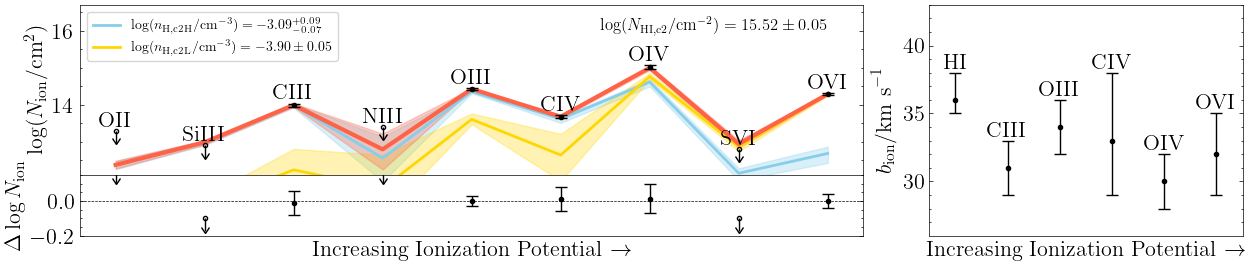

In [49]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})


axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                         gray_out = ['NeVIII'], c_dy=1.7)

axd['upper left'].set_ylim(12.1,16.7)

axd['upper left'].set_xlabel(None)

axd['upper left'].text(len(logN_dict)-1, 16., r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 15.52 \pm 0.05$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) = -3.09_{-0.07}^{+0.09}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) = -3.90 \pm 0.05$'))
    
axd['upper left'].legend(handles=handles, loc='upper left', fontsize=10)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.05)
# For non-detections not in residual panel
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.05)

axd['lower left'].set_ylim(-0.2,0.15)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'])
axd['right'].set_xlim(-0.5, 5.5)
axd['right'].set_ylim(26,43)


plt.subplots_adjust(wspace=0.12, hspace=0)  

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

In [46]:
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

Text(0, 0.5, '$\\Delta \\log N_\\mathrm{ion}$')

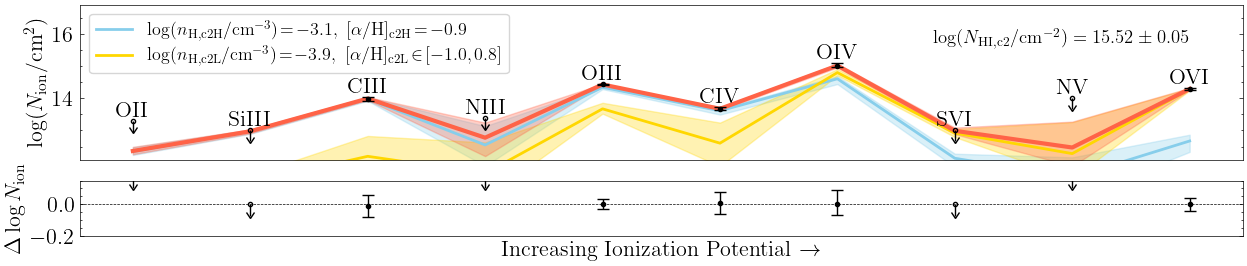

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict, fig, axes[0],
                         gray_out = ['NeVIII'], c_dy=1.7)

axes[0].set_ylim(12.1,16.9)

axes[0].set_xlabel(None)

axes[0].text(len(logN_dict)-1, 15.7, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 15.52 \pm 0.05$', fontsize=13.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) \!=\! -3.1, \ \mathrm{[\alpha/H]_{c2H}}\!=\!-0.9$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) \!=\! -3.9, \ \mathrm{[\alpha/H]_{c2L}}\!\in\![-1.0,0.8]$'))
    
axes[0].legend(handles=handles, loc='upper left', fontsize=13, ncol=1, labelspacing=.3)

plot_column_densities_obs(logN_res_dict, fig, axes[1], label_ions=False, dy=.05)
# For non-detections not in residual panel
plot_column_densities_obs(logN_res_up, fig, axes[1], label_ions=False, dy=.05)

axes[1].set_ylim(-0.2,0.15)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)